## Examine the 10x UMI for potential Aberrations

Whether or not 10x suffers from insertion/deletion or breakage errors is an open question. Here we do some basic analyses to add to this discussion. 

In [16]:
from collections import Counter
from scsequtil import fastq
import pygtrie
import pandas as pd
import numpy as np
from operator import itemgetter
import random
from scipy.stats import normaltest
import matplotlib.pyplot as plt
%matplotlib inline

First, download the 10x whitelist from the SEQC public repository, and a large 10x datafile from our group. 

In [ ]:
!aws s3 cp s3://seqc-public/barcodes/ten_x_v2/flat/737K-august-2016.txt ~/Desktop/
!aws s3 cp s3://dp-lab-data/ms5034/sc-seq/bone_marrow/10x/Run4_full_length/Run4_SI-GA-H11_merged.fastq.gz /Users/ajc/Desktop/10x_bigfile.fastq.gz

The first question we want to ask is whether we observe truncations in the 10x barcodes. Truncations could occur from: 

1. point mutations, 
2. barcode recombination or barcode breakage events or 
3. barcode insertions or deletions

We'll start by making a Trie data structure out of the 10x whitelist. This allows fast identification of the longest prefix of a barcode, which will let us find truncation rates. 

For now, lets run on uncorrected barcodes. 

In [17]:
t = pygtrie.CharTrie()
with open('/Users/ajc/Desktop/737K-august-2016.txt', 'r') as f:
    for line in f:
        t[line.strip()] = True

Count up the number of times we see each cell barcode. Here we're using an intermediate from the Pe'er lab SEQC pipeline, so the cell barcode has been prepended to the fastq name

In [144]:
rd = fastq.Reader('/Users/ajc/Desktop/10x_bigfile.fastq.gz', 'r')
counter = Counter()
for i, record in enumerate(rd):
    counter[record.name[2:18]] += 1
    if i > 1e7: 
        break

sample the first million barcodes from the file. 

In [139]:
def get_path_counts(counter, n, barcode_trie):
    short_path_counter = Counter()
    n_short_paths = Counter()
    for i, (k, v) in enumerate(counter.items()):
        if k not in t and 'N' not in k:
            while k:
                k = k[:-1]
                if barcode_trie.has_subtrie(k):
                    short_path_counter[len(k)] += v
                    n_short_paths[len(k)] += 1
                    break
        if i > n: 
            break
    path_data = pd.DataFrame({'total observations': short_path_counter, 'unique prefixes': n_short_paths})
    path_data['ratio'] = path_data['total observations'] / path_data['unique prefixes']
    path_data
    return path_data

In [145]:
path_data = get_path_counts(counter, n=1e7, barcode_trie=t)

with 370,000 barcodes, there is a null distribution that must be considered. It's probably easier to generate it empirically than to model it explicitly. So, lets generate a null distribution of the same size as our sample by generating 100% random barcodes from an ATGC alphabet

In [172]:
null_counter = Counter()
i = 0
while i < 1e6:
    random_barcode = ''.join(random.choices('ACGT', k=10))
    null_counter[random_barcode] += 1
    i += 1

In [149]:
null_path_data = get_path_counts(null_counter, 1e7, barcode_trie=t)

This does not look like a good fit for our data; random barcodes do not generate 

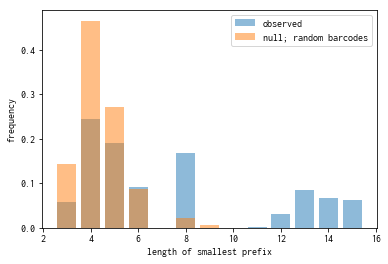

In [183]:
plt.bar(height=path_data['total observations'] / path_data['total observations'].sum(), x=path_data.index, alpha=0.5, label='observed')
plt.bar(height=null_path_data['total observations'] / null_path_data['total observations'].sum(), x=null_path_data.index, alpha=0.5, label='null; random barcodes')
plt.legend()
plt.xlabel('length of smallest prefix')
plt.ylabel('frequency');

Instead, lets now build a null distribution from barcodes consisting of only single-base errors. 

In [156]:
# build a set from the reference whitelist
with open('/Users/ajc/Desktop/737K-august-2016.txt', 'r') as f:
    true_barcodes = list(l.strip() for l in f)

null_substitution_counter = Counter()
i = 0
while i < 1e6:
    alphabet = list('ACGT')
    random_barcode = random.choice(true_barcodes)
    p = np.random.randint(0, 10)
    current_nucleotide = random_barcode[p]
    alphabet.remove(current_nucleotide)
    mutant_nucleotide = random.choice(alphabet)
    mutant_barcode = random_barcode[:p] + mutant_nucleotide + random_barcode[p + 1:]
    null_substitution_counter[mutant_barcode] += 1
    i += 1

null_mutation_path_data = get_path_counts(null_substitution_counter, n=1e6, barcode_trie=t)

This matches really quite well. It also suggests that the 10x whitelist is very weirdly distributed with an unequal distribution of hamming weights. However, we do see an uptick in long prefixes versus what is expected and decreases in 5, 6, and 8-length prefixes 

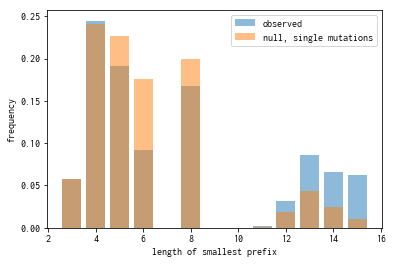

In [184]:
plt.bar(height=path_data['total observations'] / path_data['total observations'].sum(), x=path_data.index, alpha=0.5, label='observed')
plt.bar(height=null_mutation_path_data['total observations'] / null_mutation_path_data['total observations'].sum(), x=null_mutation_path_data.index, alpha=0.5, label='null, single mutations')
plt.legend()
plt.xlabel('length of smallest prefix')
plt.ylabel('frequency');

## Test UMIs

If UMIs show additional T-frequency, that would suggest that the cause is either breakage (if T increases throughout the UMI) or short deletions (if T increases only at the final position(s)). Below we measure the frequency of T-nucletides across the UMI

In [71]:
rd = fastq.Reader('/Users/ajc/Desktop/10x_bigfile.fastq.gz', 'r')
positions = np.zeros(10)
for i, record in enumerate(rd):
    is_t = np.array([1 if c == 'T' else 0 for c in record.name[19:29]])
    positions += is_t
    if i > 1e7:
        break
positions /= 1e7

Now, plot the frequency of T-nucleotides across the UMI

Text(0.5,1,'Increased T nucleotides in final UMI position')

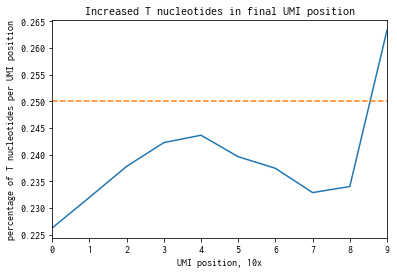

In [112]:
plt.plot(positions)
plt.plot([0.25] * 10, linestyle='--')
plt.xlim((0, 9))
plt.ylabel('percentage of T nucleotides per UMI position')
plt.xlabel('UMI position, 10x');
plt.title('Increased T nucleotides in final UMI position')

define a simple z-test, check if the last value is significantly deviating (it is)

In [105]:
from scipy.stats import norm

pop = positions[:-1]
comparison = positions[-1]
sigma = np.std(pop)
mu = np.mean(pop)
stderr = sigma / np.sqrt(pop.shape[0])
z = (comparison - mu) / stderr
print('z-score: %.2f' % z)
print('p-value: %.2g' % norm.sf(z))

z-score: 15.75
p-value: 3.4e-56


Check: Is our data gaussian? Kinda hard to tell with only 10 data points, but.. more evidence for than against. 

The below test is significant if the data _deviates_ from a normal distribution

In [187]:
normaltest(pop) 

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


NormaltestResult(statistic=0.36618081360392174, pvalue=0.83269287123452274)

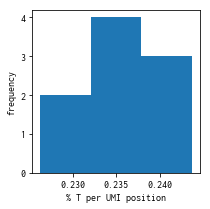

In [99]:
f, ax = plt.subplots(figsize=(3, 3))
plt.hist(pop, bins=3)
plt.ylabel('frequency')
plt.xlabel('% T per UMI position');

Assume the data is gaussian, what's the 95% confidence interval around the mean? Given that confidence interval, what's the MINIMUM effect size, accounting for maximum (95%) variance? 

In [188]:
print('high: %.3f, low: %.3f' % (mu + sigma * 1.96, mu - sigma * 1.96))
print('minimum effect size: %.3f' % (comparison - (mu + sigma * 1.96)))

high: 0.246, low: 0.226
minimum effect size: 0.017


So, at bare minimum we have a 1.7% increase in T nucleotide fraction, which could be seen as a proxy for barcode breakage. Normal barcode errors appear to occur at a similar rate, so this problem has a similar magnitude to the errors we currently detect. Unless there is an alternative explanation that I've missing, this suggests to me that it would be worthwhile for the community to address this problem.